## Goal: constrain a black-box model to be easily explainable by decision trees or decision rules

We can intuitively do: $$
\min_{\theta} L(\theta, X, Y) + \lambda \min_{\alpha} \mathbb{E}_{ \mathbf{x} \sim p(\mathbf{x})} [ KL(p_\alpha (y|\mathbf{x}))(p_\theta(y|\mathbf{x}))]
$$

Where $L(\theta, X, Y)$ is the likelihood of the black-box model $p(y|x,\theta)$ and $p(y|x,\alpha)$ is a decision tree.

Problems:
* We do not have $p(\mathbf{x})$;
* Learning a decision tree involves a non-differentiable function.

![alt text](decision_tree_rules1.png)

# The truncated normal distribution
* We can use the truncated normal distribution to learn the corresponding $\alpha$;
* An then use it to constrain the black-box model

A mixture of truncated normal distrution (which can represent a set of rules) is defined as: 
$$ p(z=k) = Cat(\pi_k)
$$
$$
p(\mathbf{x} | z = k; \mathbf{\mu}, \Sigma, \mathbf{\alpha}^1, \mathbf{\alpha}^{2})  =  \frac{\mathcal{N}(\mathbf{x}; \mathbf{\mu}_k, \Sigma_k)}{\int_{\mathbf{\alpha}^{1}_k}^{\mathbf{\alpha}^{2}_k} \mathcal{N}(\mathbf{t}; \mathbf{\mu}_k, \Sigma_k) d\mathbf{t}}  1\{\alpha^{1} \le \mathbf{x} \le \alpha^{2}\}
$$
with $\mathbf{\alpha}^{1}, \mathbf{\alpha}^{2}, \mathbf{x} \in \mathbb{R}^D$

Problem: learning the likelihood with will tend to be intractable because of piece-wise discontinuity of the function $1\{.\}$.

# The truncated normal distribution
* We can use the truncated normal distribution to learn the corresponding $\alpha$;
* An then use it to constrain the black-box model

A mixture of truncated normal distrution (which can represent a set of rules) is defined as: 
$$ p(z=k) = Cat(\pi_k)
$$
$$
p(\mathbf{x} | z = k; \mathbf{\mu}, \Sigma, \mathbf{\alpha}^1, \mathbf{\alpha}^{2})  =  \frac{\mathcal{N}(\mathbf{x}; \mathbf{\mu}_k, \Sigma_k)}{\int_{\mathbf{\alpha}^{1}_k}^{\mathbf{\alpha}^{2}_k} \mathcal{N}(\mathbf{t}; \mathbf{\mu}_k, \Sigma_k) d\mathbf{t}}  1\{\alpha^{1} \le \mathbf{x} \le \alpha^{2}\}
$$
with $\mathbf{\alpha}^{1}, \mathbf{\alpha}^{2}, \mathbf{x} \in \mathbb{R}^D$

Problem: learning the likelihood with will tend to be intractable because of piece-wise discontinuity of the function $1\{.\}$.

# The soft truncated case

$$
p(\mathbf{x} | z = k; \mathbf{\mu}, \Sigma, \mathbf{\alpha}^1, \mathbf{\alpha}^{2})  =  \frac{\mathcal{N}(\mathbf{x}; \mathbf{\mu}_k, \Sigma_k)}{\int_{\mathbf{\alpha}^{1}_k}^{\mathbf{\alpha}^{2}_k} \mathcal{N}(\mathbf{t}; \mathbf{\mu}_k, \Sigma_k) d\mathbf{t}}  \prod_{d=1}^{D}\sigma_{\eta}(x_d - \alpha^{1}_{kd})(1-\sigma_{\eta}(x_d - \alpha^{2}_{kd}))
$$
where $\sigma_{\eta}(x) = \frac{1.}{1. + \exp(-\eta\mathbf{x})}$.
The idea, being the fact that as $\eta \to \infty, \sigma_{\eta}(x)$ will be close to $1.\{x \ge 0\}$

# Important functions:

## compute_responsabilities() : E-Step

It  computes reponsibilities $$r_{ik} =p(z=k |\mathbf{x}^i) = \frac{\pi_k p(\mathbf{x}^i|z = k)} {\sum_{k_1} \pi_{k_1} p(\mathbf{x}^i|z = k_1)} $$

## M-Step: maximizing the expected likelihood (computed by __call__ function of the model)

The \__call\__ function computes:
$$Q(\Theta,\Theta^{t-1}) =\sum_i \sum_k r_{ik} \log\pi_k + \sum_i\sum_k r_{ik}\big(\log\mathcal{N}(\mathbf{x}^i;\mathbf{\mu}_k,\Sigma_k) +\sum_d \log\sigma_{\eta}(x_d^{i} - \alpha^{1}_{kd}) + \\ \log(1-\sigma_{\eta}(x_d^{i} - \alpha^{2}_{kd})) \big) - \sum_i \sum_k r_{ik} \log\int_{\mathbf{\alpha}^{1}_k}^{\mathbf{\alpha}^{2}_k} \mathcal{N}(\mathbf{t}; \mathbf{\mu}_k, \Sigma_k) d\mathbf{t}$$

To avoid numerical instabilities, all the terms are computed (as possible) in log directly.
Also, $$\log\sigma_{\eta}(x_d^{i} - \alpha^{1}_{kd}) = - \text{tf.nn.softplus}(-\eta (x_d^{i} - \alpha^{1}_{kd}) $$

### This notebook implements the mixture of soft truncated multivariate normal distribution

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.special import softmax
from scipy.special import expit
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp


from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.colors as colors
import matplotlib.cm as cm



from read_dataset_for_constraint import switch_dataset

from utils import plot_hyperrectangles, plot_pdfR

np.set_printoptions(precision=5)
tfd = tfp.distributions
np.random.seed(111)
tf.random.set_seed(111)



In [2]:

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))


TensorFlow version: 2.1.0
Eager execution: True


In [12]:
dataset_name = "data1"
type_eta = "eta_variant"
if_pca = False

X_train, y_train, X_val, y_val, X_test, y_test, y_train_onehot, y_val_onehot, y_test_onehot, scaler, color_map = \
    switch_dataset(dataset_name)(if_PCA = if_pca)

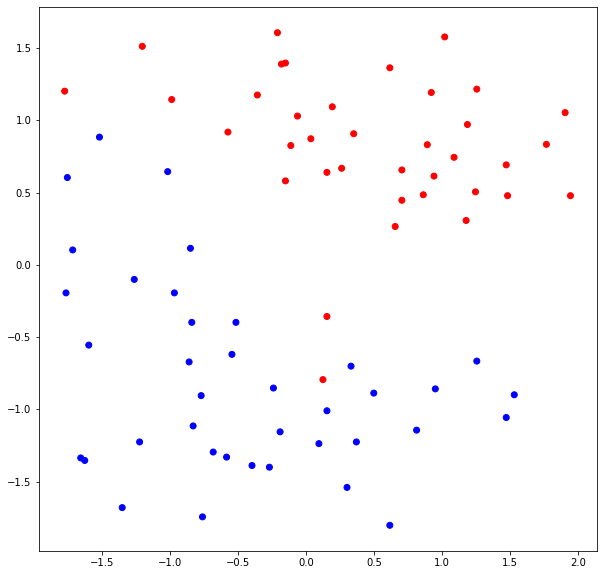

In [4]:
plt.scatter(X_train[:,0], X_train[:,1], color=[color_map[i] for i in y_train])

#plt.scatter(X_test[0],X_test[:,1], marker='^', color=[color_map[i] for i in y_test])
plt.show()

In [29]:
#M = X_train.shape[1]

number_components = 10

save_loss = []
#np.random.seed(903604963)
#np.random.seed(1595417368)
#seed = np.random.seed(159541736)
seed = np.random.seed(112)

np.random.seed(seed)
tf.random.set_seed(seed)


class SoftTruncatedGaussianMixture(tf.Module):

    def __init__(self, number_components, val_min, val_max, seed = 111):
        """ This function initilialises a model with
        logits_k = log_probabilities \pi_k probabilities of each component of the mixture
        M = number of features,
        stable = small number to for numerical instabilities
        lower = lower truncated points
        upper = upper truncated points
       """
        
        np.random.seed(seed)
        tf.random.set_seed(seed)

        self.eta = tf.Variable(0.0, trainable=False)
        self.n_components = number_components
        self.stable = tf.constant(np.finfo(np.float32).eps)

        self.data_dim = len(val_min)

        self.mu = tf.Variable(
            np.random.randn(self.n_components, self.data_dim), dtype=tf.float32, name="mu"
        )

        #This is \alpha^{1}
        self.lower = tf.Variable(
            np.random.randn(self.n_components, self.data_dim), dtype=tf.float32, name="lower"
        )

        
        #This is \alpha^{2}
        self.upper = tf.Variable(
            np.random.randn(self.n_components, self.data_dim), dtype=tf.float32, name="upper"
        )
        self.sigma = tf.Variable(
            [[0.2 for j in range(self.data_dim)] for i in range(number_components)],
            dtype=tf.float32,
            name="sigma",
        )
#         self.logits_k = tf.Variable(np.random.randn(number_components), 
#                                         dtype = tf.float32,  name= "logits")

        self.theta = tf.Variable(0.1, name = "smallest_margin", trainable = False)

       
        #self.toto = tf.Variable(0.5)*
        self.initialise_variables(val_min_in = val_min, val_max_in = val_max, seed = seed) #, 
                                 # way = "toy_example_case")         
    
    def initialise_variables(self, val_min_in, val_max_in, way = "random", seed = 111):
        """This functions helps to initiliase randomly"""
        np.random.seed(seed)
        tf.random.set_seed(seed)
        self.logits_k = tf.Variable(
            np.random.randn(self.n_components), dtype=tf.float32, name="logits"
        )

        if way == "random":
            val = np.random.uniform(
                low=val_min_in, high=val_max_in, size=(self.data_dim, self.n_components, self.data_dim)
            )
            l = np.min(val, axis=0).astype(np.float32)
            u = np.max(val, axis=0).astype(np.float32)

            self.lower.assign(l)
            self.upper.assign(u)

            self.mu.assign([(1.0 / 2) * (l[i, :] + u[i, :]) for i in range(self.n_components)])
            self.sigma.assign([[0.2 for j in range(self.data_dim)] for i in range(self.n_components)])

            # is mu = 0.5 * (lower + upper) ?
            # is sigma = 0.2 * np.ones((K, M)) ?

        if way == "toy_example_case":
            # print("toto")
            self.mu.assign([[-1.5, 0], [1.5, 0]])

            self.lower.assign([[-3.0, -3], [0, -3]])

            self.upper.assign([[0, 3.0], [3, 3]])
            self.sigma.assign([[0.2 for j in range(M)] for i in range(self.n_components)])
    
    
    def gmm_initialisation(self, X_train):
        """This function helps to initialise mu, sigma, and truncated points using a GMM"""
        
        prob_line = 3.0
        
        gmm = GaussianMixture(n_components= self.n_components, covariance_type="diag")
        gmm.fit(X_train)

        low = gmm.means_ - np.sqrt(gmm.covariances_)
        upp = gmm.means_ + 0.4*np.sqrt(gmm.covariances_)
        
        self.lower.assign(low.astype(np.float32))
        self.upper.assign(upp.astype(np.float32))
        self.mu.assign(gmm.means_.astype(np.float32))
        
        self.sigma.assign(gmm.covariances_.astype(np.float32))
         
        
    
    
    
    @tf.function
    def normalizing_constant(self, way = "independent"):
        """This function computes the normalizing constant which envolves the integral
        """
        if way == "independent":
            # Reconstructing the independent variables
            dict1 = {
                (k, d): tfd.Normal(
                    loc=self.mu[k, d],
                    scale=np.finfo(np.float32).eps + tf.nn.softplus(self.sigma[k, d]),
                )
                for d in range(self.data_dim)
                for k in range(self.n_components)
            }
            
            #Return \int_{lower}^{upper} Normal(\mu, \Sigma) dx1 ... dxn   
            return (
                tf.reduce_prod(
                    tf.stack(
                        [
                            [
                                dict1[(k, d)].cdf(self.upper[k, d])
                                - dict1[(k, d)].cdf(self.lower[k, d])
                                + self.stable
                                for d in range(self.data_dim)
                            ]
                            for k in range(self.n_components)
                        ]
                    ),
                    axis=1,
                    keepdims=True,
                )
                + self.stable
            )

        
    @tf.function
    def logistic (self, x):
        """This function return 1/(1+exp(-eta x))"""
        
        return tf.sigmoid(tf.math.multiply(self.eta,x))
    
    def compute_pdf(self, x):
        dist = (tfd.Mixture(
          cat = tfp.distributions.Categorical(logits = self.logits_k),
        components = [
            tfd.Independent(
                tfd.Normal(
                    loc = self.mu[i,:], 
                    scale = np.finfo(np.float32).eps + tf.nn.softplus(self.sigma[i,:])
                ),
                reinterpreted_batch_ndims=1
            ) 
            for i in range(self.n_components)
          ])
        )
        
        p_x_given_k = ( tf.transpose(tf.stack([dist.components[i].prob(x)  
                        for i in range(self.n_components)])/self.normalizing_constant()) )
        p_more_lower_given_x = tf.stack([x-tf.expand_dims(self.lower[i,:], 
                                                          axis=0) for i in range(self.n_components)])
        #Shape [K x N x M]
        p_less_upper_given_x = tf.stack([tf.expand_dims(self.upper[i,:], 
                                                        axis=0) - x for i in range(self.n_components)])

        
        p_more_lower_given_x = tf.transpose(tf.reduce_prod(self.logistic(p_more_lower_given_x), axis = -1))
        
        p_less_upper_given_x = tf.transpose(tf.reduce_prod(self.logistic(p_less_upper_given_x), axis = -1))
        
        p_x_given_k_trunc = tf.multiply(p_x_given_k,p_less_upper_given_x)
        

        p_x_given_k_trunc = tf.multiply(p_x_given_k_trunc,p_more_lower_given_x)
        
        return tf.math.multiply( tf.expand_dims(tf.stack(dist._cat_probs(log_probs=False)), axis = 0),
                                              p_x_given_k_trunc)
        
        
        
    @tf.function
    def __call__(self, x, responsabilities):
        """This function computes the loss function: expected log-likelihood"""

        dist = (tfd.Mixture(
          cat = tfp.distributions.Categorical(logits = self.logits_k),
        components = [
            tfd.Independent(
                tfd.Normal(
                    loc = self.mu[i,:], 
                    scale = np.finfo(np.float32).eps + tf.nn.softplus(self.sigma[i,:])
                ),
                reinterpreted_batch_ndims=1
            ) 
            for i in range(self.n_components)
          ])
        )
        #Shape [K x N x M]
        #Compute x^i_{d} - alpha^{1}
        p_more_lower_given_x = tf.stack([x-tf.expand_dims(self.lower[i,:], 
                                                          axis=0) for i in range(self.n_components)])
        #Shape [K x N x M]
        #Compute x^i_{d} - alpha^{2}
        p_less_upper_given_x = tf.stack([tf.expand_dims(self.upper[i,:], 
                                                        axis=0) - x for i in range(self.n_components)])


        
       
        log_p_more_lower_given_x = ( tf.transpose(tf.reduce_sum( - tf.nn.softplus(-self.eta *
                                                                    p_more_lower_given_x)
                                                                , axis = -1))
                                   )
        
        log_p_less_upper_given_x = (tf.transpose(tf.reduce_sum( - tf.nn.softplus(-self.eta * 
                                                                    p_less_upper_given_x)
                                                        , axis = -1))
                                   )
        
        return  ( - tf.reduce_mean(tf.multiply(responsabilities, 
                                           tf.expand_dims(dist._cat_probs(log_probs=True), 
                                                          axis = 0)))
                 
                 + tf.reduce_mean(tf.multiply(responsabilities, 
                                           tf.math.log(tf.transpose(
                                               self.normalizing_constant()
                                                                   )
                                                      )
                                             )
                                 )
                 - tf.reduce_mean(tf.multiply(responsabilities, 
                                          log_p_more_lower_given_x
                                         + log_p_less_upper_given_x
                                            )
                                 )
                - tf.reduce_mean(tf.multiply(responsabilities, 
                                           tf.transpose(tf.stack(
                                               [dist.components[i].log_prob(x)  
                                                for i in range(self.n_components)
                                               ]
                                           )
                                                       )
                                            )
                                )
               )
    
model = SoftTruncatedGaussianMixture(number_components = number_components, val_max = np.amax(X_train, axis = 0), 
                                     val_min = np.amin(X_train, axis = 0), seed= seed)
model.gmm_initialisation(X_train)


optimizer = tf.optimizers.Adam(lr = 0.001)

loss = 0.0

@tf.function
def train_step(data, responsabilities, eta):
    model.eta.assign(eta)
    with tf.GradientTape() as tape:
        current_loss = model(data, responsabilities)
    gradients = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    #Projected gradients
    val = tf.where(tf.less(model.lower + model.theta, model.upper),
                 model.lower, (0.5)*(model.upper + model.lower - model.theta))

    model.lower.assign(val)
    val = tf.where(tf.less(model.lower + model.theta, model.upper),
    model.upper, (0.5)*(model.upper + model.lower + model.theta))

    model.upper.assign(val)
    
    return current_loss, responsabilities, gradients

def compute_responsabilities(x, model):
    def logistic(eta,x):
        
        return expit(eta*x)
    
    dist1 = tfd.Mixture(
            cat = tfp.distributions.Categorical(logits = model.logits_k),
          components = [ 
              tfd.Independent(
                  tfd.Normal(
                      loc = model.mu[i,:],
                      scale = np.finfo(np.float32).eps + tf.nn.softplus(model.sigma[i,:])
                  ),
                  reinterpreted_batch_ndims = 1) for i in range(model.n_components)
          ]
    )
        
        
    
    
    p_more_lower_given_x = np.stack([x-np.expand_dims(model.lower[i,:].numpy(), 
                                                      axis=0) for i in range(model.n_components)])
    
    p_less_upper_given_x = np.stack([np.expand_dims(model.upper[i,:].numpy(), 
                                                    axis=0) - x for i in range(model.n_components)])

    
    
    
      
    log_p_more_lower_given_x = ( tf.transpose(tf.reduce_sum( - tf.nn.softplus(-model.eta *
                                                                    p_more_lower_given_x)
                                                                , axis = -1))
                                   )
        
    log_p_less_upper_given_x = (tf.transpose(tf.reduce_sum( - tf.nn.softplus(-model.eta * 
                                                                    p_less_upper_given_x)
                                                        , axis = -1))
                                   )
    
    resp = (tf.expand_dims(dist1._cat_probs(log_probs=True), axis = 0) 
            - tf.math.log(tf.transpose(model.normalizing_constant()))
            + tf.transpose(tf.stack([dist1.components[i].log_prob(x)  
                            for i in range(model.n_components)]))
            +  log_p_more_lower_given_x
            + log_p_less_upper_given_x
           )

    respo2 = softmax(resp.numpy(), axis = 1)
            
    return respo2
            
            
lloss= {}
eta = 20

tol = 0.005
loss1 = 100.0
diff = []
for i in range(50):
    #Expectation step
    directory = f"images_sTMVN/datasets/{dataset_name}/{type_eta}"
        
    if type_eta == "eta_constant":
            directory = f"{directory}/value_{eta}/components_{number_components}"
    else:
        directory = f"{directory}/components_{number_components}"
        eta = (0.5)*np.sqrt(i) + eta
        
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = f"{directory}/image" 

    responsabilities = compute_responsabilities(X_train, model)
#     plot_hyperrectangles(X_train, y_train, 0, 1, model.lower.numpy(), model.upper.numpy(), 
#                          nb_hyperrectangles = model.n_components, 
#                          file_name = f"{filename}_rectangles_{i}.png", 
#                          color_map = color_map, mu = model.mu.numpy())
    plot_pdfR(X_train[:,0], X_train[:,1], f"{filename}_density_{i}.png", model, color_map, labels = y_train, 
             n_components = number_components)
    #print(responsabilities)

    
    #Maximization
    lloss[i] = []

    for j in range(100):
        
        loss, resp, grad = train_step(data = X_train, responsabilities = responsabilities, eta = eta)
        #print(model.trainable_variables)
        #print(grad)
        loss, resp = loss.numpy(), resp.numpy() 
        lloss[i].append(loss)
        #print(grad)
    save_loss.append(loss)
    #Early stopping
    if np.abs(loss1 - loss)/loss < tol or loss <= 0.1:
        break
    else:
        diff.append(loss1-loss)
        loss1 = loss
    print(f"Iteration: {i}, loss: {loss}")
    #f = model.compute_pdf(X_train)
    #plot_pdf(X_train[:,0], X_train[:,1], f, f"images_sTMVN/image_{i}")

Iteration: 0, loss: 1.3528077602386475
Iteration: 1, loss: 0.29922351241111755
Iteration: 2, loss: 0.2678828239440918
Iteration: 3, loss: 0.24701976776123047
Iteration: 4, loss: 0.2348635196685791
Iteration: 5, loss: 0.22701340913772583
Iteration: 6, loss: 0.22119835019111633
Iteration: 7, loss: 0.21662695705890656
Iteration: 8, loss: 0.21303212642669678
Iteration: 9, loss: 0.21019256114959717
Iteration: 10, loss: 0.20781637728214264
Iteration: 11, loss: 0.20549926161766052
Iteration: 12, loss: 0.20366063714027405
Iteration: 13, loss: 0.20203447341918945
Iteration: 14, loss: 0.20057034492492676
Iteration: 15, loss: 0.19923633337020874
Iteration: 16, loss: 0.1980089396238327
Iteration: 17, loss: 0.19687071442604065
Iteration: 18, loss: 0.19580788910388947
Iteration: 19, loss: 0.19480933248996735


<Figure size 720x720 with 0 Axes>

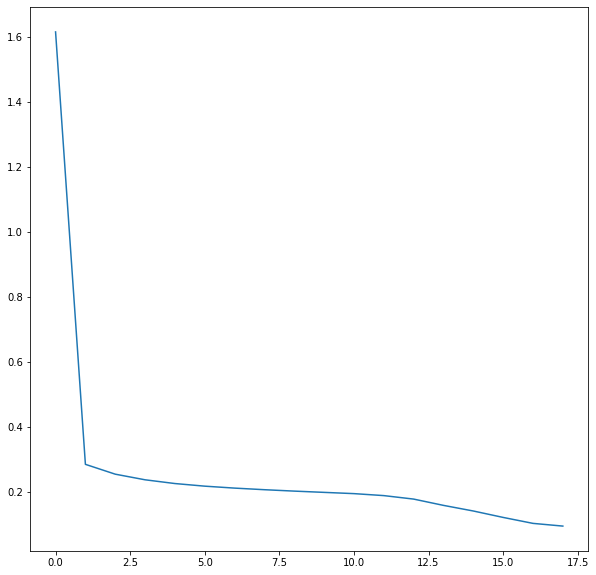

In [6]:
plt.plot(save_loss)
plt.show()

In [7]:
class testModel(tf.Module):

    def __init__(self, number_components):
        
        super(testModel, self).__init__()
        
        self.eta =  tf.Variable(0., trainable=False) 
        self.var = tf.Variable(1.0, dtype = tf.float32)
        self.var2 = tf.Variable(3.0, dtype = tf.float32)
        self.initialise_variables()
        self.M = 2
        
    @tf.function
    def initialise_variables(self):
        self.var.assign(2.0)
                              
    @tf.function
    def normalizing_constant(self, way = "independent"):
        dict1 = {(i,j): tf.square(self.var)
                 for j in range(1) for i in range(2)}
        
        return tf.reduce_sum(tf.stack([[dict1[(i,j)] for j in range(1)] for i in range(2)]))
        
    @tf.function
    def logistic (self, x):

        return tf.sigmoid(tf.math.multiply(self.eta,x))
        
    @tf.function
    def __call__(self, x):
        

        return tfd.Normal(loc = self.var, scale = self.var2).cdf(x)

    
model = testModel(2)
print(model.trainable_variables)


optimizer = tf.optimizers.Adam(lr = 0.001)

loss = 0.0
print(model.normalizing_constant())
@tf.function
def train_step(x):
    with tf.GradientTape() as tape:
        current_loss = model(x)
    gradients = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    
    return current_loss, gradients



lloss= {}
        
for i in range(1):

    #Maximization
    lloss[i] = []
    eta = (1./2) * i + 20
    for j in range(1):
        
        loss, grad = train_step(0)
        #print(model.trainable_variables)
        #print(grad)
        loss = loss.numpy() 
        lloss[i].append(loss)
        print(grad, model.trainable_variables)
    save_loss.append(loss)

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.0>)
tf.Tensor(8.0, shape=(), dtype=float32)
(<tf.Tensor: shape=(), dtype=float32, numpy=-0.10648266>, <tf.Tensor: shape=(), dtype=float32, numpy=0.07098845>) (<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.001>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.999>)
